# Build a self-attention Transformer model



### Building and training the model


In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import device
from tqdm import tqdm_notebook
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from batch_iterator import BatchIterator
from early_stopping import EarlyStopping
from tensorboardX import SummaryWriter

To train the model we will use the clean_review column from the training set as well as the label column.

In [2]:
# Import the dataset. Use clean_review and label columns
train_dataset = pd.read_csv('drugreview/drugreview_feat_clean/train_feat_clean.csv', 
                            usecols=['clean_review', 'rating'])

# Change columns order
train_dataset['label'] = train_dataset.rating >= 3
train_dataset = train_dataset[['clean_review', 'label']]

In [3]:
# Depict the first 5 rows of the training set
train_dataset = train_dataset.dropna()
train_dataset.head()

,clean_review,label
1,okay anxiety gotten worse past couple years po...,True
6,reading possible effects scary medicine gave l...,True
9,clonazepam effective controlling agitation pro...,True
11,experienced effects considering anorexia nervo...,True
12,i&#039;ve gianvi months skin clear didn&#039;t...,True


To fine-tune the hyperparameters we will evaluate the model on a validation set.

In [4]:
# Import the dataset. Use clean_review and label columns
val_dataset = pd.read_csv('drugreview/drugreview_feat_clean/val_feat_clean.csv',
                          usecols=['clean_review', 'rating'])

# Change columns order
val_dataset['label'] = val_dataset.rating >= 3
val_dataset = val_dataset[['clean_review', 'label']]

In [5]:
# Depict the first 5 rows of the validation set
val_dataset = val_dataset.dropna()
val_dataset.head()

,clean_review,label
1,4yrs having nexaplon implant mental physical h...,False
4,l5 s1 lumbar herniated disc surgery weeks surg...,True
5,far lot acne clear tea tree broke decided birt...,True
6,insulin works fine trouble pen pain pen jammed...,True
7,nexplanon option work iud painful insert pills...,True


Now we will use the BatchIterator class to preprocess the text data and generate batches.

In [6]:
batch_size = 128

In [7]:
train_iterator = BatchIterator(train_dataset, batch_size=batch_size, vocab_created=False, vocab=None, target_col=None,
                               word2index=None, sos_token='<SOS>', eos_token='<EOS>', unk_token='<UNK>',
                               pad_token='<PAD>', min_word_count=3, max_vocab_size=None, max_seq_len=0.9,
                               use_pretrained_vectors=True, glove_path='glove/', glove_name='glove.6B.100d.txt',
                               weights_file_name='glove/weights_train.npy')

Trimmed vocabulary using as minimum count threashold: count = 3.00
14773/39267 tokens has been retained
Trimmed input strings vocabulary
Trimmed input sequences lengths to the length of: 59
Mapped words to indices
Start creating glove_word2vector dictionary
Extracted 12312/14777 of pre-trained word vectors.
2465 vectors initialized to random numbers
Weights vectors saved into glove/weights_train.npy
Batches created


In [8]:
val_iterator = BatchIterator(val_dataset, batch_size=batch_size, vocab_created=False, vocab=None, target_col=None,
                             word2index=train_iterator.word2index, sos_token='<SOS>', eos_token='<EOS>',
                             unk_token='<UNK>', pad_token='<PAD>', min_word_count=3, max_vocab_size=None,
                             max_seq_len=0.9, use_pretrained_vectors=True, glove_path='glove/',
                             glove_name='glove.6B.100d.txt', weights_file_name='glove/weights_val.npy')

Trimmed vocabulary using as minimum count threashold: count = 3.00
7720/19770 tokens has been retained
Trimmed input strings vocabulary
Trimmed input sequences lengths to the length of: 58
Mapped words to indices
Start creating glove_word2vector dictionary
Extracted 12475/15036 of pre-trained word vectors.
2561 vectors initialized to random numbers
Weights vectors saved into glove/weights_val.npy
Batches created


Now we will check out if the batches look correctly.

In [9]:
for batches in train_iterator:
    # Unpack the dictionary of batches
    input_seq, target, x_lengths = batches['input_seq'], batches['target'], batches['x_lengths']
    print('input_seq shape: ', input_seq.size())
    print('target shape: ', target.size())
    print('x_lengths shape: ', x_lengths.size())
    break

input_seq shape:  torch.Size([128, 50])
target shape:  torch.Size([128])
x_lengths shape:  torch.Size([128])


In [10]:
# Extract the maximum sequence length

max_len = 0

for batches in train_iterator:
    x_lengths = batches['x_lengths']
    if max(x_lengths) > max_len:
        max_len = int(max(x_lengths))

In [11]:
print('Maximum sequence length: {}'.format(max_len))

Maximum sequence length: 60


Let's start implementing the Transformer model.

In [12]:
class MultiHeadAttention(nn.Module):

    
    def __init__(self, dmodel, heads):
        
        super(MultiHeadAttention, self).__init__()
        
        assert dmodel % heads == 0, 'Embedding dimension is not divisible by number of heads'
            
        self.dmodel = dmodel
        self.heads = heads
        # Split dmodel (embedd dimension) into 'heads' number of chunks
        # each chunk of size key_dim will be passed to different attention head
        self.key_dim = dmodel // heads
        
        # keys, queries and values will be computed at once for all heads
        self.linear = nn.ModuleList([
            nn.Linear(self.dmodel, self.dmodel, bias=False),
            nn.Linear(self.dmodel, self.dmodel, bias=False),
            nn.Linear(self.dmodel, self.dmodel, bias=False)])
        
        self.concat = nn.Linear(self.dmodel, self.dmodel, bias=False)
        
        
    def forward(self, inputs):
   
        
        self.batch_size = inputs.size(0)
        
        assert inputs.size(2) == self.dmodel, 'Input sizes mismatch, dmodel={}, while embedd={}'\
            .format(self.dmodel, inputs.size(2))

        # Inputs shape (batch_size, seq_length, embedding_dim)        
        # Map input batch allong embedd dimension to query, key and value vectors with
        # a shape of (batch_size, heads, seq_len, key_dim (dmodel // heads)) 
        # where 'heads' dimension corresponds o different attention head
        query, key, value = [linear(x).view(self.batch_size, -1, self.heads, self.key_dim).transpose(1, 2)\
                             for linear, x in zip(self.linear, (inputs, inputs, inputs))]
        
        # Calculate the score (batch_size, heads, seq_len, seq_len)
        # for all heads at once
        score = torch.matmul(query, key.transpose(-2, -1)) / np.sqrt(self.key_dim)
        
        # Apply softmax to scores (batch_size, heads, seq_len, seq_len) 
        soft_score = F.softmax(score, dim = -1)
        
        # Multiply softmaxed score and value vector
        # value input shape (batch_size, heads, seq_len, key_dim)
        # out shape (batch_size, seq_len, dmodel (key_dim * heads))
        out = torch.matmul(soft_score, value).transpose(1, 2).contiguous()\
            .view(self.batch_size, -1, self.heads * self.key_dim)
        
        # Concatenate and linearly transform heads to the lower dimensional space
        # out shape (batch_size, seq_len, dmodel)
        out = self.concat(out)
        
        return out
        
        
class PositionalEncoding(nn.Module):
    
    
    def __init__(self, max_len, dmodel, dropout, padding_idx):
        
        super(PositionalEncoding, self).__init__()
                
        self.dropout = nn.Dropout(dropout)
        
        # Create pos_encoding, positions and dimensions matrices
        # with a shape of (max_len, dmodel)
        self.pos_encoding = torch.zeros(max_len, dmodel)
        positions = torch.repeat_interleave(torch.arange(float(max_len)).unsqueeze(1), dmodel, dim=1)
        dimensions = torch.arange(float(dmodel)).repeat(max_len, 1)
                                  
        # Calculate the encodings trigonometric function argument (max_len, dmodel)
        trig_fn_arg = positions / (torch.pow(10000, 2 * dimensions / dmodel))
               
        # Encode positions using sin function for even dimensions and
        # cos function for odd dimensions
        self.pos_encoding[:, 0::2] = torch.sin(trig_fn_arg[:, 0::2])
        self.pos_encoding[:, 1::2] = torch.cos(trig_fn_arg[:, 1::2])
        
        # Set the padding positional encoding to zero tensor
        if padding_idx:
            self.pos_encoding[padding_idx] = 0.0
        
        # Add batch dimension
        self.pos_encoding = self.pos_encoding.unsqueeze(0)
        
        
    def forward(self, embedd):
        
        
        # embedd shape (batch_size, seq_length, embedding_dim)
        # pos_encoding shape (1, max_len, dmodel = embedd_dim)
        embedd = embedd + self.pos_encoding[:, :embedd.size(1), :]
        embedd = self.dropout(embedd)
        
        # embedd shape (batch_size, seq_length, embedding_dim)
        return embedd  
    
    
class LabelSmoothingLoss(nn.Module):
    
    
    def __init__(self, output_size, label_smoothing=0):

        super(LabelSmoothingLoss, self).__init__()
        
        self.output_size = output_size
        self.label_smoothing = label_smoothing
        self.confidence = 1 - self.label_smoothing
        
        assert label_smoothing >= 0.0 and label_smoothing <= 1.0, \
        'Label smoothing parameter takes values in the range [0, 1]'

        self.criterion = nn.KLDivLoss()
        
        
    def forward(self, pred, target):
       
        
        one_hot_probs = torch.full(size=pred.size(), fill_value=self.label_smoothing/(self.output_size - 1))
       
        one_hot_probs.scatter_(1, target.unsqueeze(1), self.confidence)
            
       
        return self.criterion(pred, one_hot_probs)    


In [13]:
class TransformerBlock(nn.Module):
  
    
    def __init__(self, dmodel, ffnn_hidden_size, heads, dropout):
        
        super(TransformerBlock, self).__init__()
        
        self.attention = MultiHeadAttention(dmodel, heads)
        self.layer_norm1 = nn.LayerNorm(dmodel)
        self.layer_norm2 = nn.LayerNorm(dmodel)
        
        self.ffnn = nn.Sequential(
                nn.Linear(dmodel, ffnn_hidden_size),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(ffnn_hidden_size, dmodel))
        
        
    def forward(self, inputs):
               # Inputs shape (batch_size, seq_length, embedding_dim = dmodel)
        output = inputs + self.attention(inputs)            
        output = self.layer_norm1(output)            
        output = output + self.ffnn(output)            
        output = self.layer_norm2(output)

        # Output shape (batch_size, seq_length, dmodel)
        return output
        
        
class Transformer(nn.Module):
        
    def __init__(self, vocab_size, dmodel, output_size, max_len, padding_idx=0, n_layers=4,
                 ffnn_hidden_size=None, heads=8, pooling='max', dropout=0.5):
        
        super(Transformer, self).__init__()
        
        if not ffnn_hidden_size:
            ffnn_hidden_size = dmodel * 4
            
        assert pooling == 'max' or pooling == 'avg', 'Improper pooling type was passed.'
        
        self.pooling = pooling
        self.output_size = output_size
        
        self.embedding = nn.Embedding(vocab_size, dmodel)
        
        self.pos_encoding = PositionalEncoding(max_len, dmodel, dropout, padding_idx)
        
        self.tnf_blocks = nn.ModuleList()
        
        for n in range(n_layers):
            self.tnf_blocks.append(
                TransformerBlock(dmodel, ffnn_hidden_size, heads, dropout))
            
        self.tnf_blocks = nn.Sequential(*self.tnf_blocks)
            
        self.linear = nn.Linear(dmodel, output_size)
        
        
    def forward(self, inputs, input_lengths):
       
        self.batch_size = inputs.size(0)
        
        # Input dimensions (batch_size, seq_length, dmodel)
        output = self.embedding(inputs)
        output = self.pos_encoding(output)
        output = self.tnf_blocks(output)
        # Output dimensions (batch_size, seq_length, dmodel)
        
        if self.pooling == 'max':
            # Permute to the shape (batch_size, dmodel, seq_length)
            # Apply max-pooling, output dimensions (batch_size, dmodel)
            output = F.adaptive_max_pool1d(output.permute(0,2,1), (1,)).view(self.batch_size,-1)
        else:
            # Sum along the batch axis and divide by the corresponding lengths (FloatTensor)
            # Output shape: (batch_size, dmodel)
            output = torch.sum(output, dim=1) / input_lengths.view(-1,1).type(torch.FloatTensor) 
            
        output = self.linear(output)
        
        return F.log_softmax(output, dim=-1)
        
        
    def add_loss_fn(self, loss_fn):
   
        self.loss_fn = loss_fn
        

    def add_optimizer(self, optimizer):

        self.optimizer = optimizer
        
        
    def add_device(self, device=torch.device('cpu')):

        self.device = device
    
    
    def train_model(self, train_iterator):

        self.train()
        
        train_losses = []
        losses = []
        losses_list = []
        num_seq = 0
        batch_correct = 0
            
        for i, batches in tqdm_notebook(enumerate(train_iterator, 1), total=len(train_iterator), desc='Training'):
            input_seq, target, x_lengths = batches['input_seq'], batches['target'], batches['x_lengths']
            
            input_seq.to(self.device)
            target.to(self.device)
            x_lengths.to(self.device)
            
            self.optimizer.zero_grad()

            pred = self.forward(input_seq, x_lengths)
            loss = self.loss_fn(pred, target)
            loss.backward()
            losses.append(loss.data.cpu().numpy())
            self.optimizer.step()
            
            losses_list.append(loss.data.cpu().numpy())
            
            pred = torch.argmax(pred, 1)

            if self.device.type == 'cpu':
                batch_correct += (pred.cpu() == target.cpu()).sum().item()

            else:
                batch_correct += (pred == target).sum().item()

            num_seq += len(input_seq)     
    
            if i % 100 == 0:
                avg_train_loss = np.mean(losses)
                train_losses.append(avg_train_loss)
                
                accuracy = batch_correct / num_seq
                
                print('Iteration: {}. Average training loss: {:.4f}. Accuracy: {:.3f}'\
                      .format(i, avg_train_loss, accuracy))
                
                losses = []
                
            avg_loss = np.mean(losses_list)
            accuracy = batch_correct / num_seq
                              
        return train_losses, avg_loss, accuracy
    
    
    def evaluate_model(self, eval_iterator, conf_mtx=False):

        self.eval()
        
        eval_losses = []
        losses = []
        losses_list = []
        num_seq = 0
        batch_correct = 0
        pred_total = torch.LongTensor()
        target_total = torch.LongTensor()
        
        with torch.no_grad():
            for i, batches in tqdm_notebook(enumerate(eval_iterator, 1), total=len(eval_iterator), desc='Evaluation'):
                input_seq, target, x_lengths = batches['input_seq'], batches['target'], batches['x_lengths']
                
                input_seq.to(self.device)
                target.to(self.device)
                x_lengths.to(self.device)

                pred = self.forward(input_seq, x_lengths)
                loss = self.loss_fn(pred, target)
                losses.append(loss.data.cpu().numpy())
                losses_list.append(loss.data.cpu().numpy())
                
                pred = torch.argmax(pred, 1)
                                
                if self.device.type == 'cpu':
                    batch_correct += (pred.cpu() == target.cpu()).sum().item()
                    
                else:
                    batch_correct += (pred == target).sum().item()
                    
                num_seq += len(input_seq)     
                
                pred_total = torch.cat([pred_total, pred], dim=0)
                target_total = torch.cat([target_total, target], dim=0)
                
                if i % 100 == 0:
                    avg_batch_eval_loss = np.mean(losses)
                    eval_losses.append(avg_batch_eval_loss)
                    
                    accuracy = batch_correct / num_seq
                    
                    print('Iteration: {}. Average evaluation loss: {:.4f}. Accuracy: {:.2f}'\
                          .format(i, avg_batch_eval_loss, accuracy))

                    losses = []
                    
            avg_loss_list = []
                    
            avg_loss = np.mean(losses_list)
            accuracy = batch_correct / num_seq
            
            conf_matrix = confusion_matrix(target_total.view(-1), pred_total.view(-1))
        
        if conf_mtx:
            print('\tConfusion matrix: ', conf_matrix)
            
        return eval_losses, avg_loss, accuracy, conf_matrix
    

In [14]:
# Initialize parameters
vocab_size = len(train_iterator.word2index)
dmodel = 64
output_size = 2
padding_idx = train_iterator.word2index['<PAD>']
n_layers = 4
ffnn_hidden_size = dmodel * 2
heads = 8
pooling = 'max'
dropout = 0.8
label_smoothing = 0.1
learning_rate = 0.001
epochs = 30

# Check whether system supports CUDA
CUDA = torch.cuda.is_available()

model = Transformer(vocab_size, dmodel, output_size, max_len, padding_idx, n_layers,\
                    ffnn_hidden_size, heads, pooling, dropout)

# Move the model to GPU if possible
if CUDA:
    model.cuda()
    
# Add loss function    
if label_smoothing:
    loss_fn = LabelSmoothingLoss(output_size, label_smoothing)
else:
    loss_fn = nn.NLLLoss()
    
model.add_loss_fn(loss_fn)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model.add_optimizer(optimizer)

device = torch.device('cuda' if CUDA else 'cpu')

model.add_device(device)

# Create the parameters dictionary and instantiate the tensorboardX SummaryWriter
params = {'batch_size': batch_size,
          'dmodel': dmodel,
          'n_layers': n_layers,
          'ffnn_hidden_size': ffnn_hidden_size,
          'heads': heads,
          'pooling': pooling,
          'dropout': dropout,
          'label_smoothing': label_smoothing,
          'learning_rate': learning_rate}

train_writer = SummaryWriter(comment=f' Training, batch_size={batch_size}, dmodel={dmodel}, n_layers={n_layers},\
ffnn_hidden_size={ffnn_hidden_size}, heads={heads}, pooling={pooling}, dropout={dropout}, \
label_smoothing={label_smoothing}, learning_rate={learning_rate}'.format(**params))

val_writer = SummaryWriter(comment=f' Validation, batch_size={batch_size}, dmodel={dmodel}, n_layers={n_layers},\
ffnn_hidden_size={ffnn_hidden_size}, heads={heads}, pooling={pooling}, dropout={dropout}, \
label_smoothing={label_smoothing}, learning_rate={learning_rate}'.format(**params))

# Instantiate the EarlyStopping
early_stop = EarlyStopping(wait_epochs=3)

train_losses_list, train_avg_loss_list, train_accuracy_list = [], [], []
eval_avg_loss_list, eval_accuracy_list, conf_matrix_list = [], [], []

for epoch in range(epochs):
    
    try:
        print('\nStart epoch [{}/{}]'.format(epoch+1, epochs))

        train_losses, train_avg_loss, train_accuracy = model.train_model(train_iterator)

        train_losses_list.append(train_losses)
        train_avg_loss_list.append(train_avg_loss)
        train_accuracy_list.append(train_accuracy)

        _, eval_avg_loss, eval_accuracy, conf_matrix = model.evaluate_model(val_iterator)

        eval_avg_loss_list.append(eval_avg_loss)
        eval_accuracy_list.append(eval_accuracy)
        conf_matrix_list.append(conf_matrix)

        print('\nEpoch [{}/{}]: Train accuracy: {:.3f}. Train loss: {:.4f}. Evaluation accuracy: {:.3f}. Evaluation loss: {:.4f}'\
              .format(epoch+1, epochs, train_accuracy, train_avg_loss, eval_accuracy, eval_avg_loss))

        train_writer.add_scalar('Training loss', train_avg_loss, epoch)
        val_writer.add_scalar('Validation loss', eval_avg_loss, epoch)

        if early_stop.stop(eval_avg_loss, model, delta=0.003):
            break

    finally:
        train_writer.close()
        val_writer.close()



Start epoch [1/30]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.1236. Accuracy: 0.817
Iteration: 200. Average training loss: 0.1158. Accuracy: 0.820
Iteration: 300. Average training loss: 0.1134. Accuracy: 0.823


Evaluation:   0%|          | 0/90 [00:00<?, ?it/s]


Epoch [1/30]: Train accuracy: 0.821. Train loss: 0.1180. Evaluation accuracy: 0.822. Evaluation loss: 0.1193

Start epoch [2/30]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.1134. Accuracy: 0.825
Iteration: 200. Average training loss: 0.1152. Accuracy: 0.824
Iteration: 300. Average training loss: 0.1129. Accuracy: 0.825


Evaluation:   0%|          | 0/90 [00:00<?, ?it/s]


Epoch [2/30]: Train accuracy: 0.824. Train loss: 0.1146. Evaluation accuracy: 0.822. Evaluation loss: 0.1237

Start epoch [3/30]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.1130. Accuracy: 0.825
Iteration: 200. Average training loss: 0.1150. Accuracy: 0.824
Iteration: 300. Average training loss: 0.1124. Accuracy: 0.825


Evaluation:   0%|          | 0/90 [00:00<?, ?it/s]


Epoch [3/30]: Train accuracy: 0.824. Train loss: 0.1143. Evaluation accuracy: 0.822. Evaluation loss: 0.1236

Start epoch [4/30]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.1128. Accuracy: 0.825
Iteration: 200. Average training loss: 0.1138. Accuracy: 0.824
Iteration: 300. Average training loss: 0.1109. Accuracy: 0.825


Evaluation:   0%|          | 0/90 [00:00<?, ?it/s]


Epoch [4/30]: Train accuracy: 0.824. Train loss: 0.1129. Evaluation accuracy: 0.823. Evaluation loss: 0.1097

Start epoch [5/30]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.1093. Accuracy: 0.825
Iteration: 200. Average training loss: 0.1100. Accuracy: 0.824
Iteration: 300. Average training loss: 0.1073. Accuracy: 0.825


Evaluation:   0%|          | 0/90 [00:00<?, ?it/s]


Epoch [5/30]: Train accuracy: 0.823. Train loss: 0.1092. Evaluation accuracy: 0.822. Evaluation loss: 0.0993

Start epoch [6/30]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.1058. Accuracy: 0.825
Iteration: 200. Average training loss: 0.1061. Accuracy: 0.824
Iteration: 300. Average training loss: 0.1037. Accuracy: 0.825


Evaluation:   0%|          | 0/90 [00:00<?, ?it/s]


Epoch [6/30]: Train accuracy: 0.823. Train loss: 0.1052. Evaluation accuracy: 0.822. Evaluation loss: 0.0984

Start epoch [7/30]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.1014. Accuracy: 0.826
Iteration: 200. Average training loss: 0.1031. Accuracy: 0.825
Iteration: 300. Average training loss: 0.1002. Accuracy: 0.826


Evaluation:   0%|          | 0/90 [00:00<?, ?it/s]


Epoch [7/30]: Train accuracy: 0.825. Train loss: 0.1017. Evaluation accuracy: 0.841. Evaluation loss: 0.0918

Start epoch [8/30]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.0993. Accuracy: 0.825
Iteration: 200. Average training loss: 0.1003. Accuracy: 0.825
Iteration: 300. Average training loss: 0.0981. Accuracy: 0.827


Evaluation:   0%|          | 0/90 [00:00<?, ?it/s]


Epoch [8/30]: Train accuracy: 0.826. Train loss: 0.0995. Evaluation accuracy: 0.842. Evaluation loss: 0.0893

Start epoch [9/30]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.0962. Accuracy: 0.832
Iteration: 200. Average training loss: 0.0970. Accuracy: 0.832
Iteration: 300. Average training loss: 0.0945. Accuracy: 0.832


Evaluation:   0%|          | 0/90 [00:00<?, ?it/s]


Epoch [9/30]: Train accuracy: 0.831. Train loss: 0.0963. Evaluation accuracy: 0.847. Evaluation loss: 0.0868

Start epoch [10/30]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.0951. Accuracy: 0.833
Iteration: 200. Average training loss: 0.0955. Accuracy: 0.833
Iteration: 300. Average training loss: 0.0924. Accuracy: 0.835


Evaluation:   0%|          | 0/90 [00:00<?, ?it/s]


Epoch [10/30]: Train accuracy: 0.834. Train loss: 0.0947. Evaluation accuracy: 0.847. Evaluation loss: 0.0850

Start epoch [11/30]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.0927. Accuracy: 0.835
Iteration: 200. Average training loss: 0.0939. Accuracy: 0.836
Iteration: 300. Average training loss: 0.0911. Accuracy: 0.837


Evaluation:   0%|          | 0/90 [00:00<?, ?it/s]


Epoch [11/30]: Train accuracy: 0.836. Train loss: 0.0927. Evaluation accuracy: 0.845. Evaluation loss: 0.0845

Start epoch [12/30]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.0914. Accuracy: 0.838
Iteration: 200. Average training loss: 0.0931. Accuracy: 0.835
Iteration: 300. Average training loss: 0.0898. Accuracy: 0.838


Evaluation:   0%|          | 0/90 [00:00<?, ?it/s]


Epoch [12/30]: Train accuracy: 0.838. Train loss: 0.0916. Evaluation accuracy: 0.851. Evaluation loss: 0.0830

Start epoch [13/30]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.0896. Accuracy: 0.838
Iteration: 200. Average training loss: 0.0909. Accuracy: 0.840
Iteration: 300. Average training loss: 0.0897. Accuracy: 0.839


Evaluation:   0%|          | 0/90 [00:00<?, ?it/s]


Epoch [13/30]: Train accuracy: 0.838. Train loss: 0.0905. Evaluation accuracy: 0.840. Evaluation loss: 0.0843

Start epoch [14/30]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.0879. Accuracy: 0.844
Iteration: 200. Average training loss: 0.0920. Accuracy: 0.840
Iteration: 300. Average training loss: 0.0871. Accuracy: 0.842


Evaluation:   0%|          | 0/90 [00:00<?, ?it/s]


Epoch [14/30]: Train accuracy: 0.841. Train loss: 0.0893. Evaluation accuracy: 0.847. Evaluation loss: 0.0830

Start epoch [15/30]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.0885. Accuracy: 0.845
Iteration: 200. Average training loss: 0.0894. Accuracy: 0.844
Iteration: 300. Average training loss: 0.0857. Accuracy: 0.845


Evaluation:   0%|          | 0/90 [00:00<?, ?it/s]


Epoch [15/30]: Train accuracy: 0.844. Train loss: 0.0882. Evaluation accuracy: 0.854. Evaluation loss: 0.0817

Start epoch [16/30]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.0859. Accuracy: 0.847
Iteration: 200. Average training loss: 0.0879. Accuracy: 0.845
Iteration: 300. Average training loss: 0.0853. Accuracy: 0.846


Evaluation:   0%|          | 0/90 [00:00<?, ?it/s]


Epoch [16/30]: Train accuracy: 0.845. Train loss: 0.0866. Evaluation accuracy: 0.853. Evaluation loss: 0.0814

Start epoch [17/30]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.0868. Accuracy: 0.847
Iteration: 200. Average training loss: 0.0867. Accuracy: 0.846
Iteration: 300. Average training loss: 0.0849. Accuracy: 0.847


Evaluation:   0%|          | 0/90 [00:00<?, ?it/s]


Epoch [17/30]: Train accuracy: 0.847. Train loss: 0.0860. Evaluation accuracy: 0.853. Evaluation loss: 0.0799

Start epoch [18/30]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.0838. Accuracy: 0.852
Iteration: 200. Average training loss: 0.0872. Accuracy: 0.847
Iteration: 300. Average training loss: 0.0839. Accuracy: 0.848


Evaluation:   0%|          | 0/90 [00:00<?, ?it/s]


Epoch [18/30]: Train accuracy: 0.847. Train loss: 0.0854. Evaluation accuracy: 0.852. Evaluation loss: 0.0794

Start epoch [19/30]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.0842. Accuracy: 0.851
Iteration: 200. Average training loss: 0.0858. Accuracy: 0.850
Iteration: 300. Average training loss: 0.0830. Accuracy: 0.851


Evaluation:   0%|          | 0/90 [00:00<?, ?it/s]


Epoch [19/30]: Train accuracy: 0.850. Train loss: 0.0844. Evaluation accuracy: 0.856. Evaluation loss: 0.0790

Start epoch [20/30]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.0836. Accuracy: 0.848
Iteration: 200. Average training loss: 0.0858. Accuracy: 0.847
Iteration: 300. Average training loss: 0.0828. Accuracy: 0.849


Evaluation:   0%|          | 0/90 [00:00<?, ?it/s]


Epoch [20/30]: Train accuracy: 0.848. Train loss: 0.0842. Evaluation accuracy: 0.853. Evaluation loss: 0.0797

Start epoch [21/30]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.0821. Accuracy: 0.853
Iteration: 200. Average training loss: 0.0845. Accuracy: 0.851
Iteration: 300. Average training loss: 0.0818. Accuracy: 0.851


Evaluation:   0%|          | 0/90 [00:00<?, ?it/s]


Epoch [21/30]: Train accuracy: 0.850. Train loss: 0.0831. Evaluation accuracy: 0.855. Evaluation loss: 0.0788

Start epoch [22/30]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.0809. Accuracy: 0.857
Iteration: 200. Average training loss: 0.0834. Accuracy: 0.854
Iteration: 300. Average training loss: 0.0802. Accuracy: 0.855


Evaluation:   0%|          | 0/90 [00:00<?, ?it/s]


Epoch [22/30]: Train accuracy: 0.854. Train loss: 0.0817. Evaluation accuracy: 0.860. Evaluation loss: 0.0785

Start epoch [23/30]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.0820. Accuracy: 0.857
Iteration: 200. Average training loss: 0.0827. Accuracy: 0.854
Iteration: 300. Average training loss: 0.0799. Accuracy: 0.855


Evaluation:   0%|          | 0/90 [00:00<?, ?it/s]


Epoch [23/30]: Train accuracy: 0.854. Train loss: 0.0817. Evaluation accuracy: 0.860. Evaluation loss: 0.0779

Start epoch [24/30]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.0807. Accuracy: 0.857
Iteration: 200. Average training loss: 0.0826. Accuracy: 0.854
Iteration: 300. Average training loss: 0.0800. Accuracy: 0.856


Evaluation:   0%|          | 0/90 [00:00<?, ?it/s]


Epoch [24/30]: Train accuracy: 0.855. Train loss: 0.0811. Evaluation accuracy: 0.857. Evaluation loss: 0.0782

Start epoch [25/30]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.0788. Accuracy: 0.863
Iteration: 200. Average training loss: 0.0815. Accuracy: 0.858
Iteration: 300. Average training loss: 0.0782. Accuracy: 0.859


Evaluation:   0%|          | 0/90 [00:00<?, ?it/s]


Epoch [25/30]: Train accuracy: 0.859. Train loss: 0.0796. Evaluation accuracy: 0.862. Evaluation loss: 0.0787

Start epoch [26/30]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.0797. Accuracy: 0.857
Iteration: 200. Average training loss: 0.0812. Accuracy: 0.857
Iteration: 300. Average training loss: 0.0791. Accuracy: 0.858


Evaluation:   0%|          | 0/90 [00:00<?, ?it/s]


Epoch [26/30]: Train accuracy: 0.857. Train loss: 0.0801. Evaluation accuracy: 0.862. Evaluation loss: 0.0774

Start epoch [27/30]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.0790. Accuracy: 0.858
Iteration: 200. Average training loss: 0.0803. Accuracy: 0.858
Iteration: 300. Average training loss: 0.0774. Accuracy: 0.860


Evaluation:   0%|          | 0/90 [00:00<?, ?it/s]


Epoch [27/30]: Train accuracy: 0.860. Train loss: 0.0791. Evaluation accuracy: 0.863. Evaluation loss: 0.0773

Start epoch [28/30]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.0778. Accuracy: 0.861
Iteration: 200. Average training loss: 0.0796. Accuracy: 0.859
Iteration: 300. Average training loss: 0.0761. Accuracy: 0.862


Evaluation:   0%|          | 0/90 [00:00<?, ?it/s]


Epoch [28/30]: Train accuracy: 0.861. Train loss: 0.0780. Evaluation accuracy: 0.862. Evaluation loss: 0.0774

Start epoch [29/30]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.0777. Accuracy: 0.861
Iteration: 200. Average training loss: 0.0812. Accuracy: 0.858
Iteration: 300. Average training loss: 0.0767. Accuracy: 0.859


Evaluation:   0%|          | 0/90 [00:00<?, ?it/s]


Epoch [29/30]: Train accuracy: 0.859. Train loss: 0.0786. Evaluation accuracy: 0.863. Evaluation loss: 0.0774

Start epoch [30/30]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.0773. Accuracy: 0.863
Iteration: 200. Average training loss: 0.0795. Accuracy: 0.860
Iteration: 300. Average training loss: 0.0753. Accuracy: 0.863


Evaluation:   0%|          | 0/90 [00:00<?, ?it/s]


Epoch [30/30]: Train accuracy: 0.863. Train loss: 0.0773. Evaluation accuracy: 0.862. Evaluation loss: 0.0779


In [15]:
train_avg_loss_list.insert(0, train_losses_list[0][0])
eval_avg_loss_list.insert(0, train_losses_list[0][0])

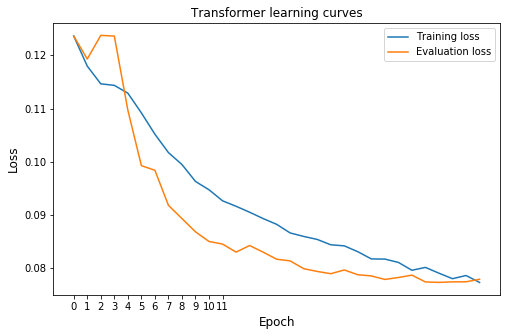

In [16]:
# Plot the training and the validation learning curve
plt.figure(figsize=(8,5))
plt.plot(train_avg_loss_list, label='Training loss')
plt.plot(eval_avg_loss_list, label='Evaluation loss')
plt.xlabel('Epoch', size=12)
plt.ylabel('Loss', size=12)
plt.title('Transformer learning curves')
plt.xticks(ticks=range(12))
plt.legend()
plt.show()

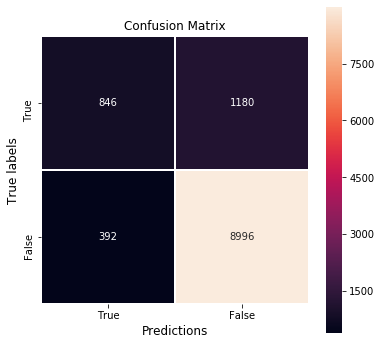

In [17]:
# Confusion matrix
plt.figure(figsize=(6,6))
ax = sns.heatmap(conf_matrix, fmt='d', annot=True, linewidths=1, square=True)
ax.set_xlabel('Predictions', size=12)
ax.set_ylabel('True labels', size=12) 
ax.set_title('Confusion Matrix', size=12); 
ax.xaxis.set_ticklabels(['True', 'False'])
ax.yaxis.set_ticklabels(['True', 'False'])
ax.set_ylim(2,0)
plt.show()

### The generalization error

In [18]:
# Import the dataset. Use clean_review and label columns
test_dataset = pd.read_csv('drugreview/drugreview_feat_clean/test_feat_clean.csv',
                          usecols=['clean_review', 'rating'])

# Change columns order
test_dataset['label'] = test_dataset.rating >= 5
test_dataset = test_dataset[['clean_review', 'label']]

In [19]:
test_dataset = test_dataset.dropna()
test_dataset.head()

,clean_review,label
0,i&#039;ve tried antidepressants years citalopr...,True
1,son crohn&#039;s disease asacol complaints sho...,True
2,quick reduction symptoms,True
3,contrave combines drugs alcohol smoking opioid...,True
4,birth control cycle reading reviews type simil...,True


In [20]:
test_iterator = BatchIterator(test_dataset, batch_size=256, vocab_created=False, vocab=None, target_col=None,
                              word2index=train_iterator.word2index, sos_token='<SOS>', eos_token='<EOS>',
                              unk_token='<UNK>', pad_token='<PAD>', min_word_count=3, max_vocab_size=None,
                              max_seq_len=0.9, use_pretrained_vectors=True, glove_path='glove/',
                              glove_name='glove.6B.100d.txt', weights_file_name='glove/weights_train.npy')

Trimmed vocabulary using as minimum count threashold: count = 3.00
15210/40911 tokens has been retained
Trimmed input strings vocabulary
Trimmed input sequences lengths to the length of: 59
Mapped words to indices
Start creating glove_word2vector dictionary
Extracted 13890/17168 of pre-trained word vectors.
3278 vectors initialized to random numbers
Weights vectors saved into glove/weights_train.npy
Batches created


In [21]:
_, test_avg_loss, test_accuracy, test_conf_matrix = model.evaluate_model(test_iterator)

Evaluation:   0%|          | 0/189 [00:00<?, ?it/s]

Iteration: 100. Average evaluation loss: 0.0968. Accuracy: 0.82


In [22]:
print('Test accuracy: {:.3f}. Test error: {:.3f}'.format(test_accuracy, test_avg_loss))

Test accuracy: 0.822. Test error: 0.096


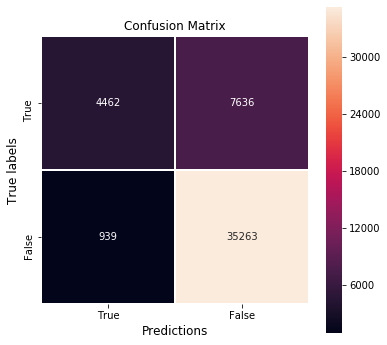

In [23]:
# Confusion matrix
plt.figure(figsize=(6,6))
ax = sns.heatmap(test_conf_matrix, fmt='d', annot=True, linewidths=1, square=True)
ax.set_xlabel('Predictions', size=12)
ax.set_ylabel('True labels', size=12) 
ax.set_title('Confusion Matrix', size=12); 
ax.xaxis.set_ticklabels(['True', 'False'])
ax.yaxis.set_ticklabels(['True', 'False'])
ax.set_ylim(2,0)
plt.show()